<a href="https://colab.research.google.com/github/natnj/NJ-projects-pub/blob/main/MLCB_Homework_4_NJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLCB Homework 4

**Due: Monday Nov 13th at 11:59 PM EDT**

If you have any questions, please ask on piazza or at office hours!

Copy this notebook, and answer all questions directly in this notebook and complete the missing code where marked with **COMPLETE HERE**.

When you are done, submit the .ipynb file as well as PDF to Canvas.

## 0. Setup (run this)

In [23]:
from scipy.stats import ranksums, ttest_ind
from matplotlib_venn import venn2

In [10]:
!pip install scikit-learn
!pip install scipy
!pip install numpy
!pip install scanpy
!pip install anndata
!pip install leidenalg
!pip install rdkit

import scanpy as sc
import anndata
import os
import pandas as pd
import scipy.io as io
import numpy as np
from google.colab import files
from scipy.spatial.transform import Rotation
from rdkit import Chem
from rdkit.Chem import AllChem

## Download the data
!wget -c -O data.zip https://www.dropbox.com/sh/4f9fmenyvmrffj2/AAAmNwJtO8ZKTaRkZoltTCHsa?dl=0
!unzip -o data.zip -d data

!wget -c -O diffdock.zip https://www.dropbox.com/scl/fi/e23wyl4bfolckjaaablhc/diffdock.zip?rlkey=80p9a46yivyc3jdi7jnq7bnx9&dl=0
!unzip -o diffdock.zip -d diffdock


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=2c4f299d5e2a02c031b998b1dbf8b8b24e6d39279ce88d45f96fc02c84d8da41
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=8b1e29effdcb46b91ddfc0441a3d6cef20dfc458cf6a584a53659b3eb8ae7448
  Stored in directory: /root/.cache/pip/wheels/6a/

## 1. Single-cell RNA-seq Data Analysis

In this problem, we will analyse single cell RNA-seq data, including clustering, identifying marker genes per cell type and look at differential expression under varied conditions.

First run the extra setup below:

In [2]:
## Read data and create anndata object
# load sparse matrix :
X = io.mmread("data/counts.mtx")
# create anndata object
adata = anndata.AnnData(X=X.transpose().tocsr() )
# load cell metadata:
cell_meta = pd.read_csv("data/meta.csv")
# load gene names:
with open("data/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names


In [3]:
## Since the provided data was pre-processed, we will skip the data fitering steps.
## Perform log-transformation, scale data, and identify highly variable genes
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

### 1.A Visualization and Clustering

In this part, you will perform dimensionality reduction (PCA) technique to emphasize the main axes of variation in the data, compuate neighborhood graph to identify clusters of cells that have similar expression patterns, run tSNE and UMAP for further dimensionality reduction to visualize clusters in 2D, and find clusters using Leiden graph-clustering method based on the neighborhood graph of cells, which you already computed in the previous section. Please use the scanpy build-in functions for this question.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


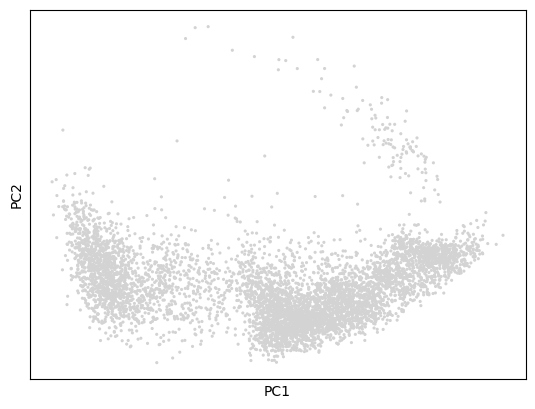

In [4]:
import matplotlib.pyplot as plt
## Run PCA and plot
sc.tl.pca(adata)
sc.pl.pca(adata)


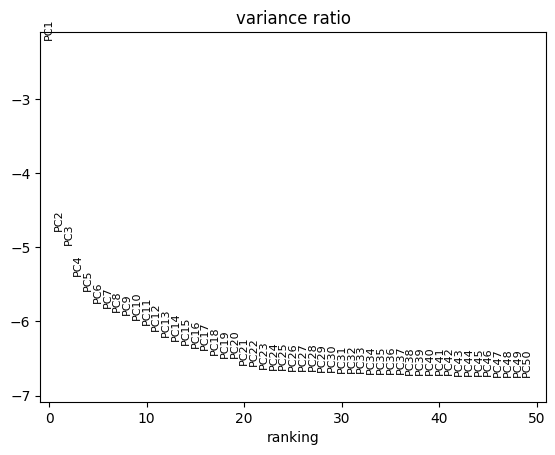

In [5]:
## Number of PCs selection
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)


In [6]:
## Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, method='umap', metric='cosine', knn=True)

# Optionally, you can compute a force-directed layout for visualization

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


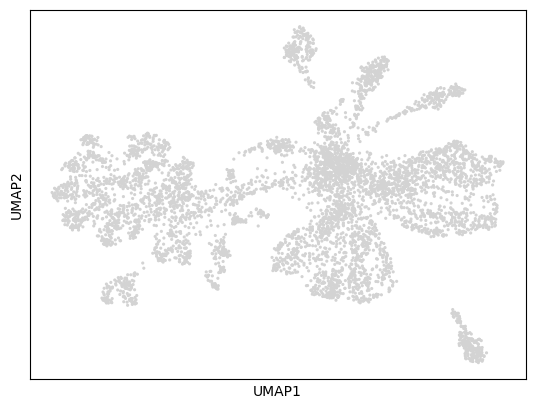

In [7]:
## Run clustering and plot
sc.tl.umap(adata)
sc.pl.umap(adata)
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


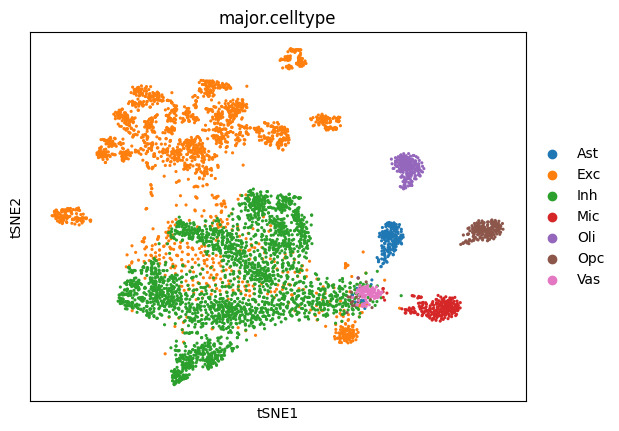

In [8]:
## Run tSNE and plot, colored by cluster id which you get in the clustering step, colored by "major.celltype" in the metadata
sc.tl.tsne(adata)
sc.pl.tsne(adata, color='major.celltype')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


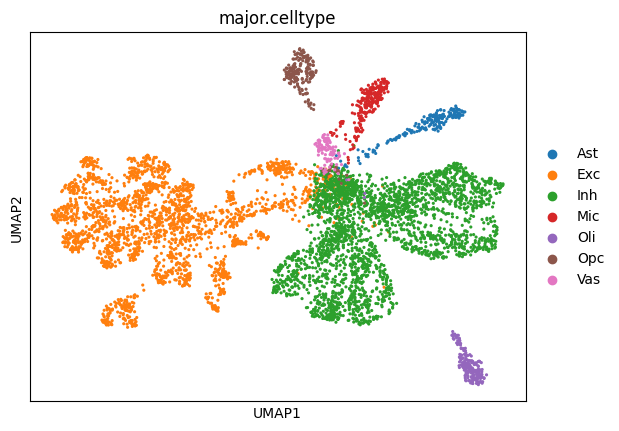

In [10]:
## Run UMAP and plot, colored by cluster id which you get in the clustering step, colored by "major.celltype" in the metadata
sc.tl.umap(adata)
sc.pl.umap(adata, color='major.celltype')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


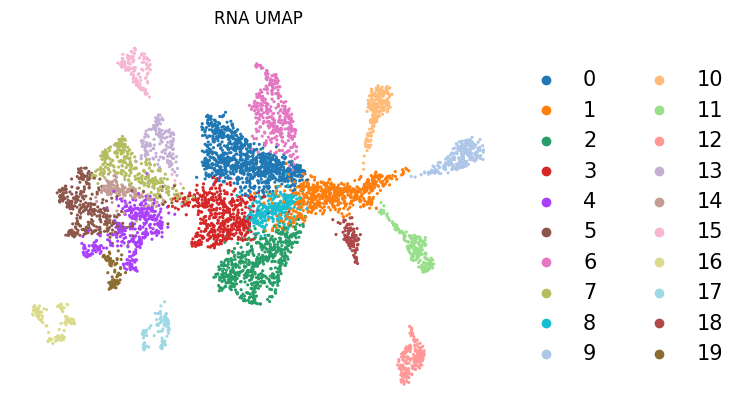

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

Compare the plots of tSNE and UMAP. Please also discuss the differences between these two methods in general.



**ANSWER:**

The biggest difference, on the outset is the number of clusters.


UMAP and t-SNE are both dimensionality reduction techniques for visualizing high-dimensional data. While t-SNE focuses on preserving local structures, UMAP aims to capture both local and global relationships in the data. UMAP is often more computationally efficient, with a scalable implementation suitable for large datasets. Unlike t-SNE, UMAP exhibits greater stability across multiple runs. The choice between UMAP and t-SNE depends on factors such as the dataset size, the need for preserving global structures, and computational efficiency.


### 1.B Find marker genes per cluster and annotate cell type

In this part, you will identify marker genes for each cluster and use the reference marker panel to annotate the cell type for each cluster.
Reference marker genes for the brain cell types:

Markers | Cell Type
---|---
SYT1,SNAP25,GRIN1 | Neurons
NRGN, SLC17A7,CAMK2A | Excitatory neurons
GAD1,GAD2 |	Inhibitory neurons
AQP4,GFAP |	Astrocytes
MBP, MOBP,PLP1 | 	Oligodendrocytes
CSF1R, CD74,C3 |	Microglia
VCAN, PDGFRA,CSPG4 |	Oligodendrocyte progenitor cells (Opc)
FLT1,CLDN5,AMBP |	Vascular cells

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: 

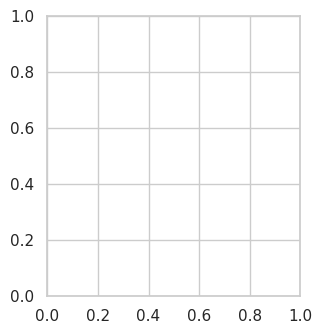

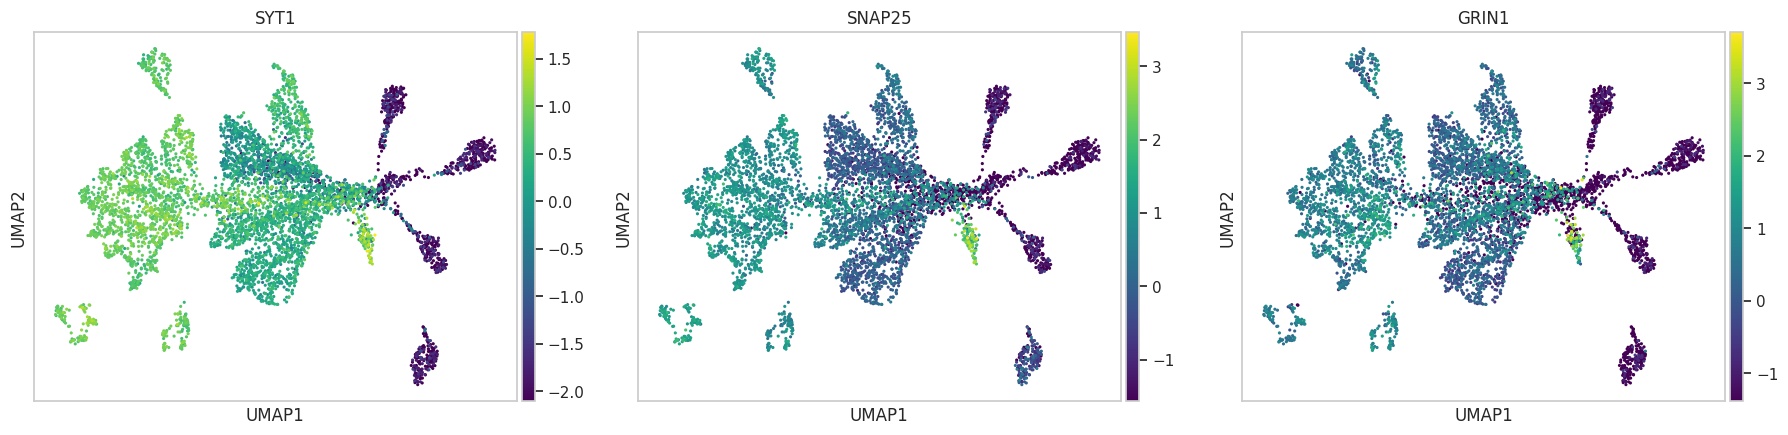

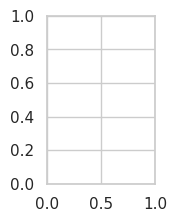

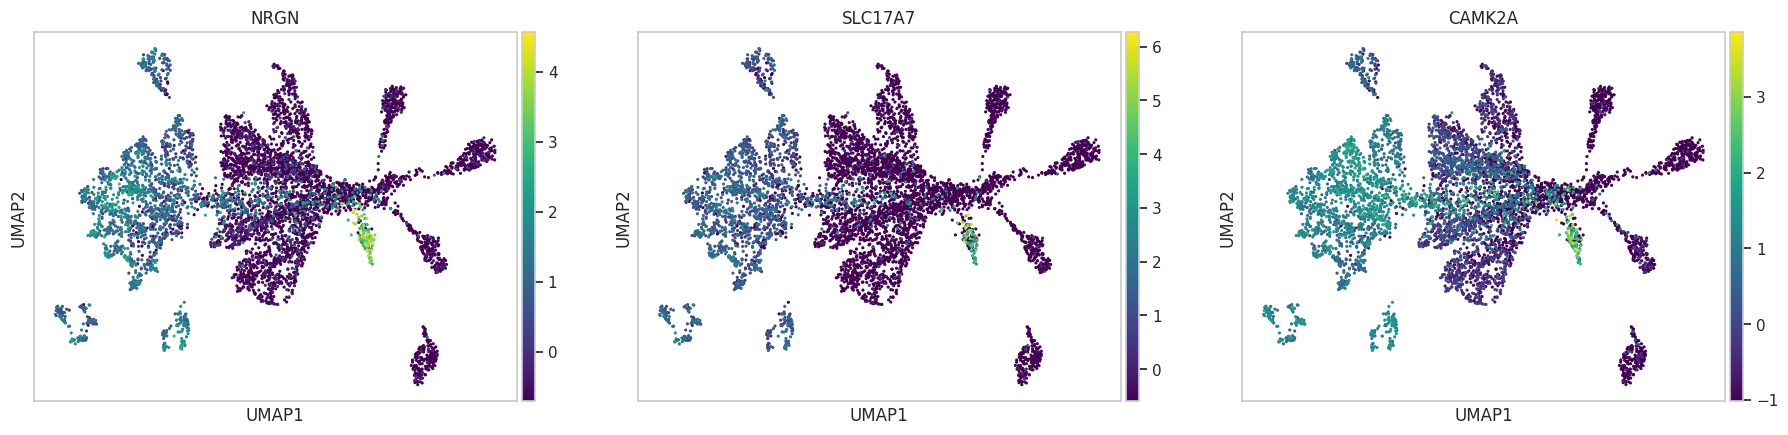

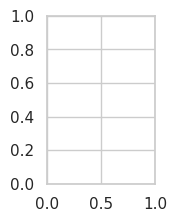

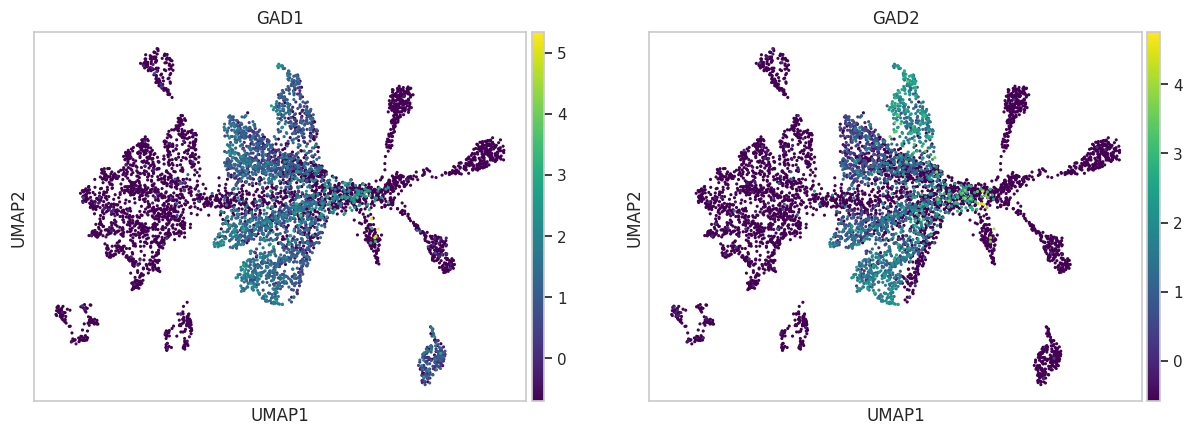

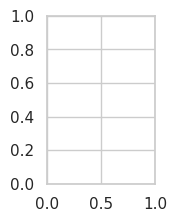

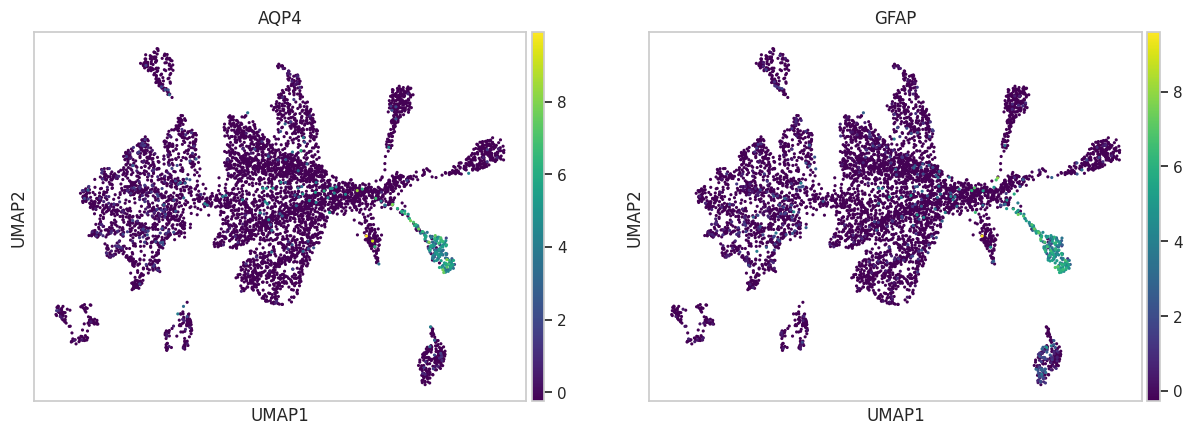

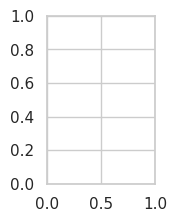

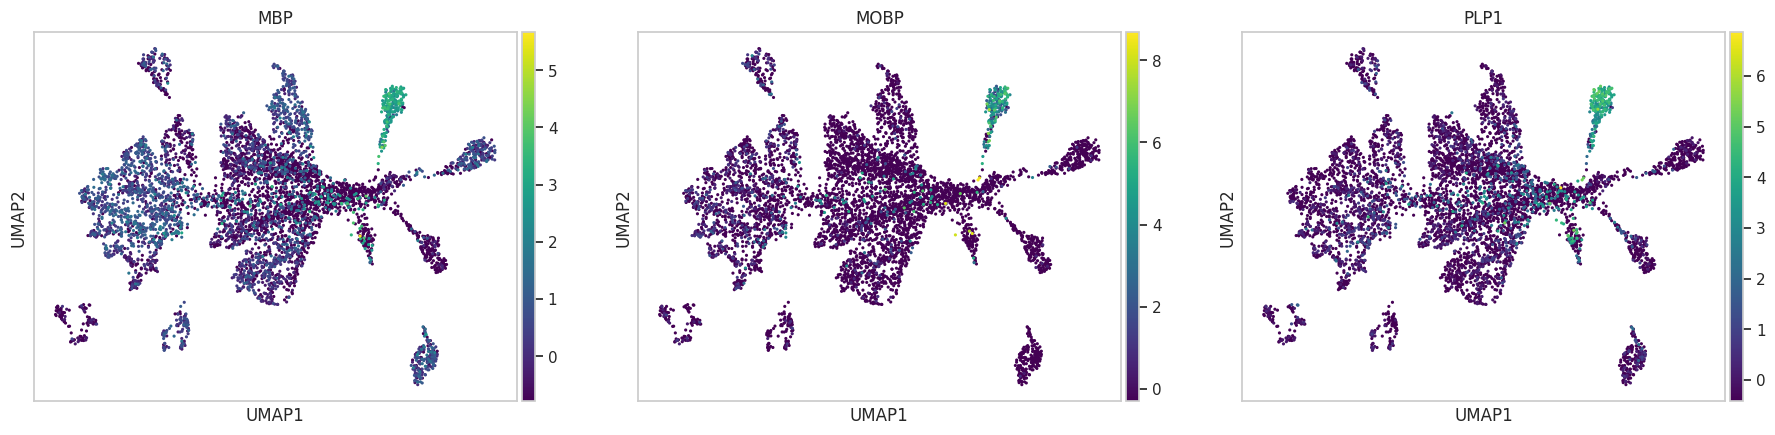

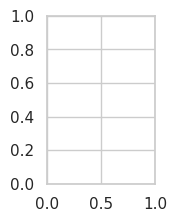

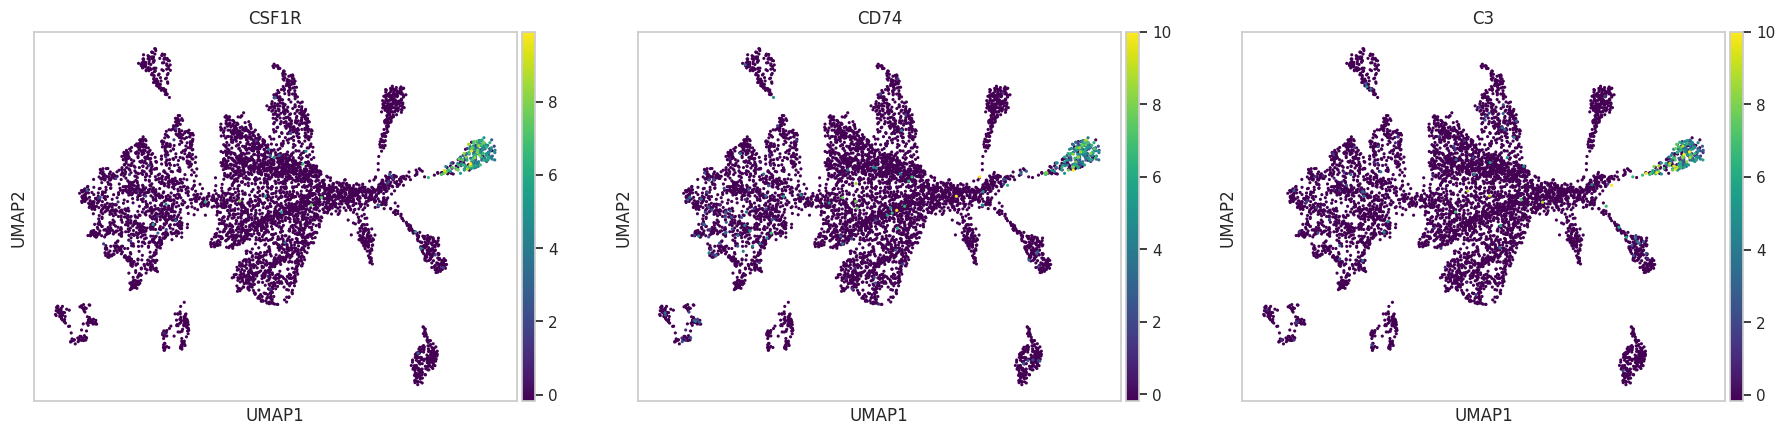

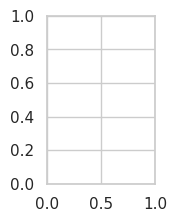

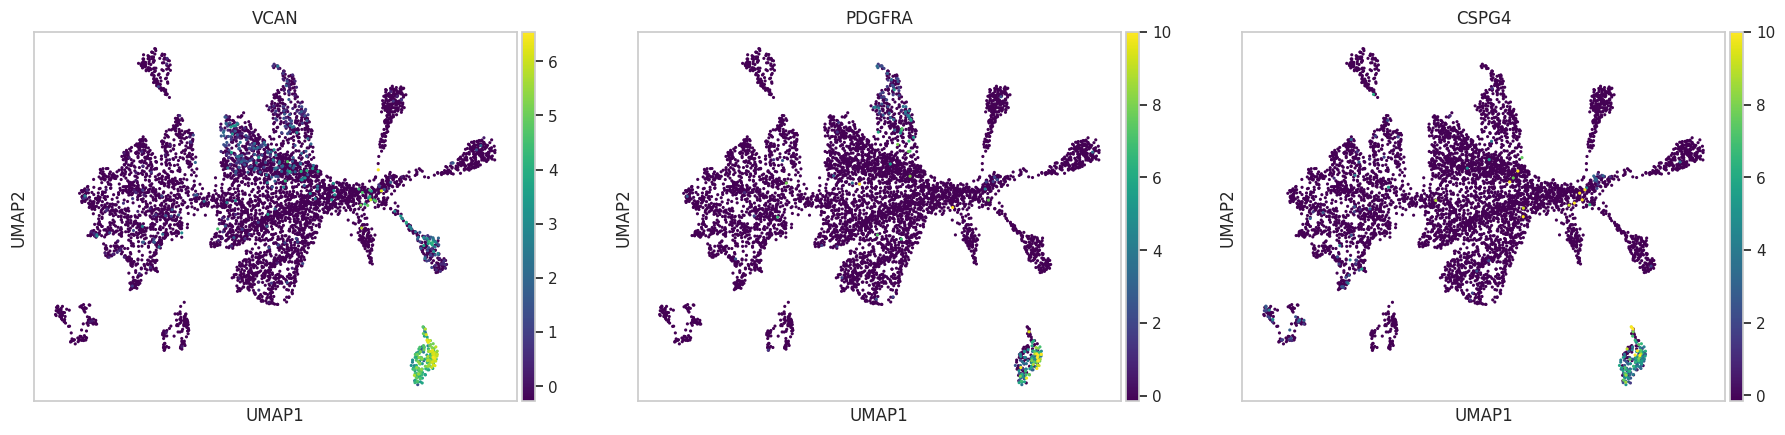

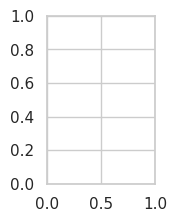

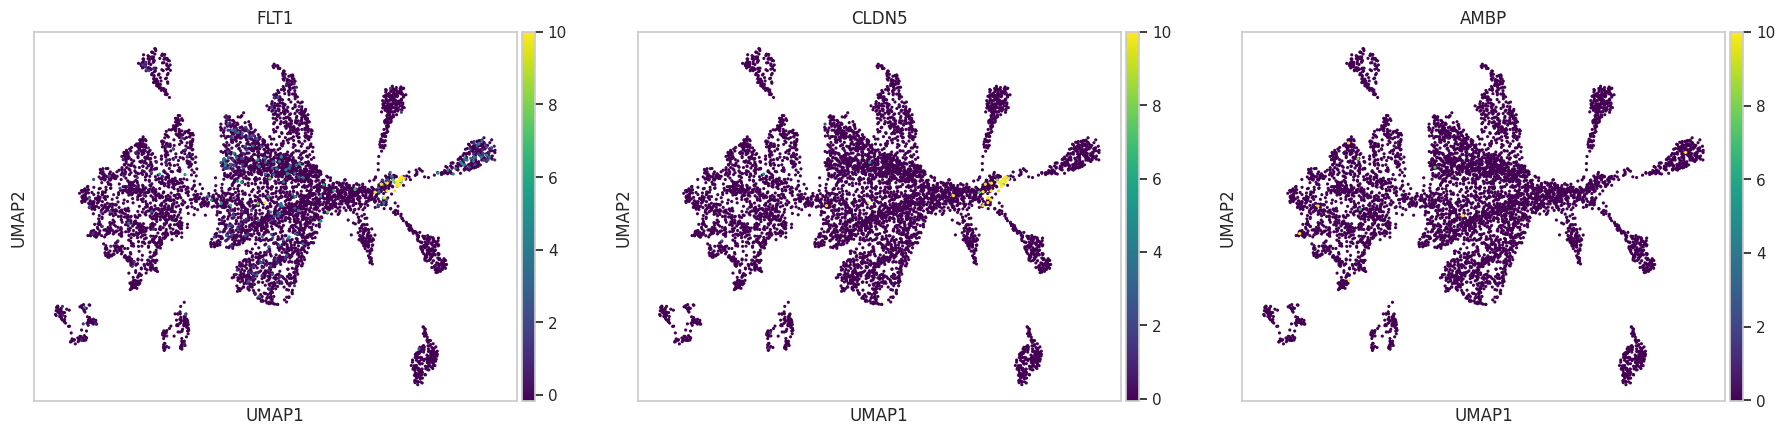

<Figure size 640x480 with 0 Axes>

In [27]:
import seaborn as sns

# Define the reference marker panel
reference_markers = {
    'Neurons': ['SYT1', 'SNAP25', 'GRIN1'],
    'Excitatory neurons': ['NRGN', 'SLC17A7', 'CAMK2A'],
    'Inhibitory neurons': ['GAD1', 'GAD2'],
    'Astrocytes': ['AQP4', 'GFAP'],
    'Oligodendrocytes': ['MBP', 'MOBP', 'PLP1'],
    'Microglia': ['CSF1R', 'CD74', 'C3'],
    'Oligodendrocyte progenitor cells (Opc)': ['VCAN', 'PDGFRA', 'CSPG4'],
    'Vascular cells': ['FLT1', 'CLDN5', 'AMBP']
}

# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', reference='rest')

# Extract marker genes and scores
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = pd.DataFrame({group: result['names'][group] for group in groups})
marker_scores = pd.DataFrame({group: result['scores'][group] for group in groups})

# Plot expression of marker genes on UMAP
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

for i, (cell_type, genes) in enumerate(reference_markers.items(), 1):
    plt.subplot(2, 4, i)
    sc.pl.umap(adata, color=genes, use_raw=False, cmap='viridis', legend_loc='on data')

plt.tight_layout()
plt.show()



/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


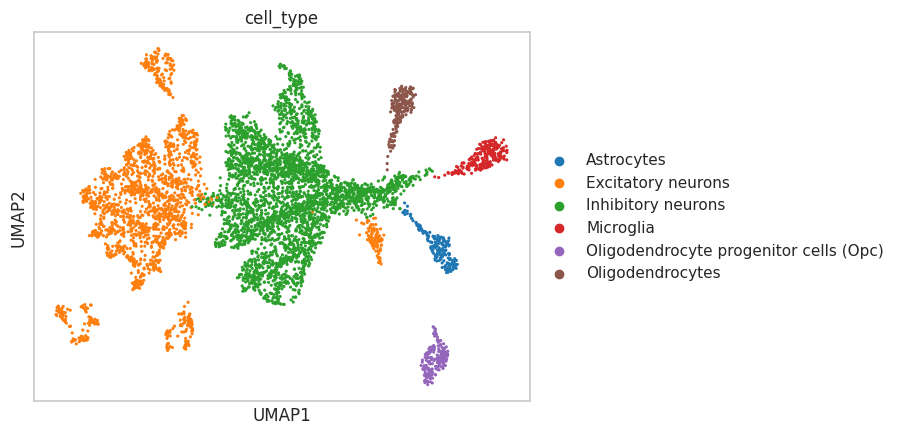

In [28]:
# plot UMAP colored with your cell type annotation and compare it with the "major.celltype" in the metadata
annotation_dict={
 '0': 'Inhibitory neurons',
 '1': 'Inhibitory neurons',
 '2': 'Inhibitory neurons',
 '3': 'Inhibitory neurons',
 '4': 'Excitatory neurons',
 '5': 'Excitatory neurons',
 '6': 'Inhibitory neurons',
 '7': 'Excitatory neurons',
 '8': 'Inhibitory neurons',
 '9': 'Microglia',
 '10': 'Oligodendrocytes',
 '11': 'Astrocytes',
 '12': 'Oligodendrocyte progenitor cells (Opc)',
 '13': 'Excitatory neurons',
 '14': 'Excitatory neurons',
 '15': 'Excitatory neurons',
 '16': 'Excitatory neurons',
 '17': 'Excitatory neurons',
 '18': 'Excitatory neurons',
 '19': 'Excitatory neurons'}

adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')



Please describe your observation of the comparison between your annotation and "major.celltype".

**ANSWER:** There are different subsections of cells that are marked in my annotation, and there seems to be less overlap, but this may be down to my human categorical perception

### 1.C Differential Gene Expression Analysis between Conditions

In this part, we will identify differentially expressed genes (DEGs) between conditions (AD vs. nonAD) per cell type. You may find the "condition" in the metadata. Please call DEGs using two methods: wilcoxon and t-test, visulize the top 10 DEGs per group, and compare your results between two methods and visulize the comparison using venn diagram. For each cell type, you will generate two comparions (up-regulated in AD; up-regulated in nonAD).

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: P

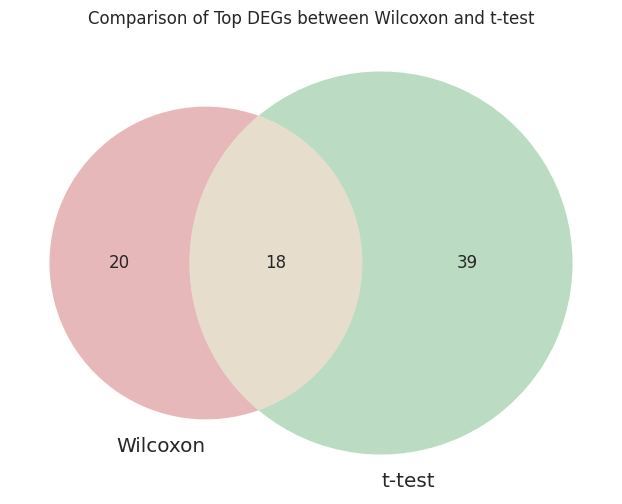

In [47]:
# Your code and plot
# Define conditions
condition_ad = 'AD'
condition_nonad = 'nonAD'

# Define cell types
cell_types = ['Neurons', 'Excitatory neurons', 'Inhibitory neurons', 'Astrocytes',
              'Oligodendrocytes', 'Microglia', 'Oligodendrocyte progenitor cells (Opc)',
              'Vascular cells']

# Perform DE analysis for each cell type
de_results_wilcoxon = {}
de_results_ttest = {}

for cell_type in cell_types:
    # Subset data for the specific cell type
    adata_cell_type = adata[adata.obs['cell_type'] == cell_type, :]

    # Subset data for each condition
    adata_ad = adata_cell_type[adata_cell_type.obs['condition'] == condition_ad, :]
    adata_nonad = adata_cell_type[adata_cell_type.obs['condition'] == condition_nonad, :]

    # Perform Wilcoxon test
    _, pvals_wilcoxon = ranksums(adata_ad.X, adata_nonad.X)

    # Perform t-test
    _, pvals_ttest = ttest_ind(adata_ad.X, adata_nonad.X)

    # Store DE results
    de_results_wilcoxon[cell_type] = pd.DataFrame({'gene': adata.var_names, 'pval': pvals_wilcoxon})
    de_results_ttest[cell_type] = pd.DataFrame({'gene': adata.var_names, 'pval': pvals_ttest})

# Visualize the top 10 DEGs per group
top_genes_wilcoxon = {}
top_genes_ttest = {}

for cell_type in cell_types:
    top_genes_wilcoxon[cell_type] = de_results_wilcoxon[cell_type].nlargest(10, 'pval')['gene'].tolist()
    top_genes_ttest[cell_type] = de_results_ttest[cell_type].nlargest(10, 'pval')['gene'].tolist()

# Compare DE results using Venn diagrams
venn_sets = {'Wilcoxon': set(), 't-test': set()}

for cell_type in cell_types:
    venn_sets['Wilcoxon'].update(top_genes_wilcoxon[cell_type])
    venn_sets['t-test'].update(top_genes_ttest[cell_type])

# Plot Venn diagram
plt.figure(figsize=(10, 6))
venn2([venn_sets['Wilcoxon'], venn_sets['t-test']], set_labels=('Wilcoxon', 't-test'))
plt.title('Comparison of Top DEGs between Wilcoxon and t-test')
plt.show()

**ANSWER:**

Venn diagram is annotated to indicate which genes are up-regulated in AD, up-regulated in nonAD, or shared between the two conditions. When there is a significant overlap between the top DEGs identified by both methods, it suggests consistency in the findings, and higher likelihood of biological significance


## 2. Molecular Docking








In lecture we studied the task of molecular docking: given a protein target's structure in 3D, we wish to find the 3D coordinates of a known ligand binder. In particular we showed some deep learning approaches to the problem.

In this problem, we first review the question of symmetry preserving models, which is particuarly important to 3D tasks such as molecular docking. Then, we will run a few docking predictions using DiffDock (https://arxiv.org/abs/2210.01776) and analyze them.

### 2.A Invariance & Equivariance

Because the docking task is inherently a 3D task (i.e we are predicting coordinates), it's important to think about the geometrical symmetries that we wish our model to handle gracefully. We call this family of models "invariant" or "equivariant" to a group transformation. This is particularly neat property that significantly reduces the space of functions that the model considers, helping optimization and generalization.

#### 2.A.1 Question

What does it mean for a model to be invariant to translations and rotations of the input? How about equivariant? Give a simple mathematical definition using `f` as the model function, `x` as the input, `R` as a rotation matrix, and `t` as a translation vector.




**ANSWER**:
* Invariance: The model's output does not change when the input is transformed.
    * f(R⋅x+t)=f(x)
* Equivariance: The model's output transforms in a consistent manner with the input transformations.
    * f(R⋅x+t)=R⋅f(x)+t


#### 2.A.2 Question

There are many ways to achieve invariance / equivariance, and it is currently a very active area of research. Here, we will study the the Equivariant Graph Neural Network (EGNN)  model by Satoras et. al: (https://arxiv.org/pdf/2102.09844.pdf).

Recall the GNN layer we implemented in Homework 2, with node features `h` and edge features `e`. We compute messages for each edge, aggregate the messages and used the result to update the features:

$$ \begin{align} m_{ij} &= MLP(h_i, h_j, e_{ij}) \\
 m_i &= \frac{1}{N} \sum_j m_{ij} \\
 \tilde{h_i} &= MLP(h_i, m_i) \end{align}$$


An EGNN layer is very similar, defined by the following set of equations, given a set of input features `h` and coordinates `x`:

$$ \begin{align} m_{ij} &= MLP(h_i, h_j, e_{ij}, ||x_i - x_j||^2) \\
 m_i &= \frac{1}{N} \sum_j m_{ij} \\
h_{new} &= MLP(h_i, m_i) \\
x_{new} &= x_i + \frac{1}{N} \sum_j MLP(m_{ij}) \cdot (\vec{x_i}- \vec{x_j}) \end{align}$$


The only changes are the use of pairwise distances in the first equation and the coordinate update in the last equation.

Prove that EGNN is indeed equivariant to translation and rotation by showing that applying a rotation `R` and translation `t` to the input `x_i` and `x_j` is equivalent to applying it to the output `x_new`.


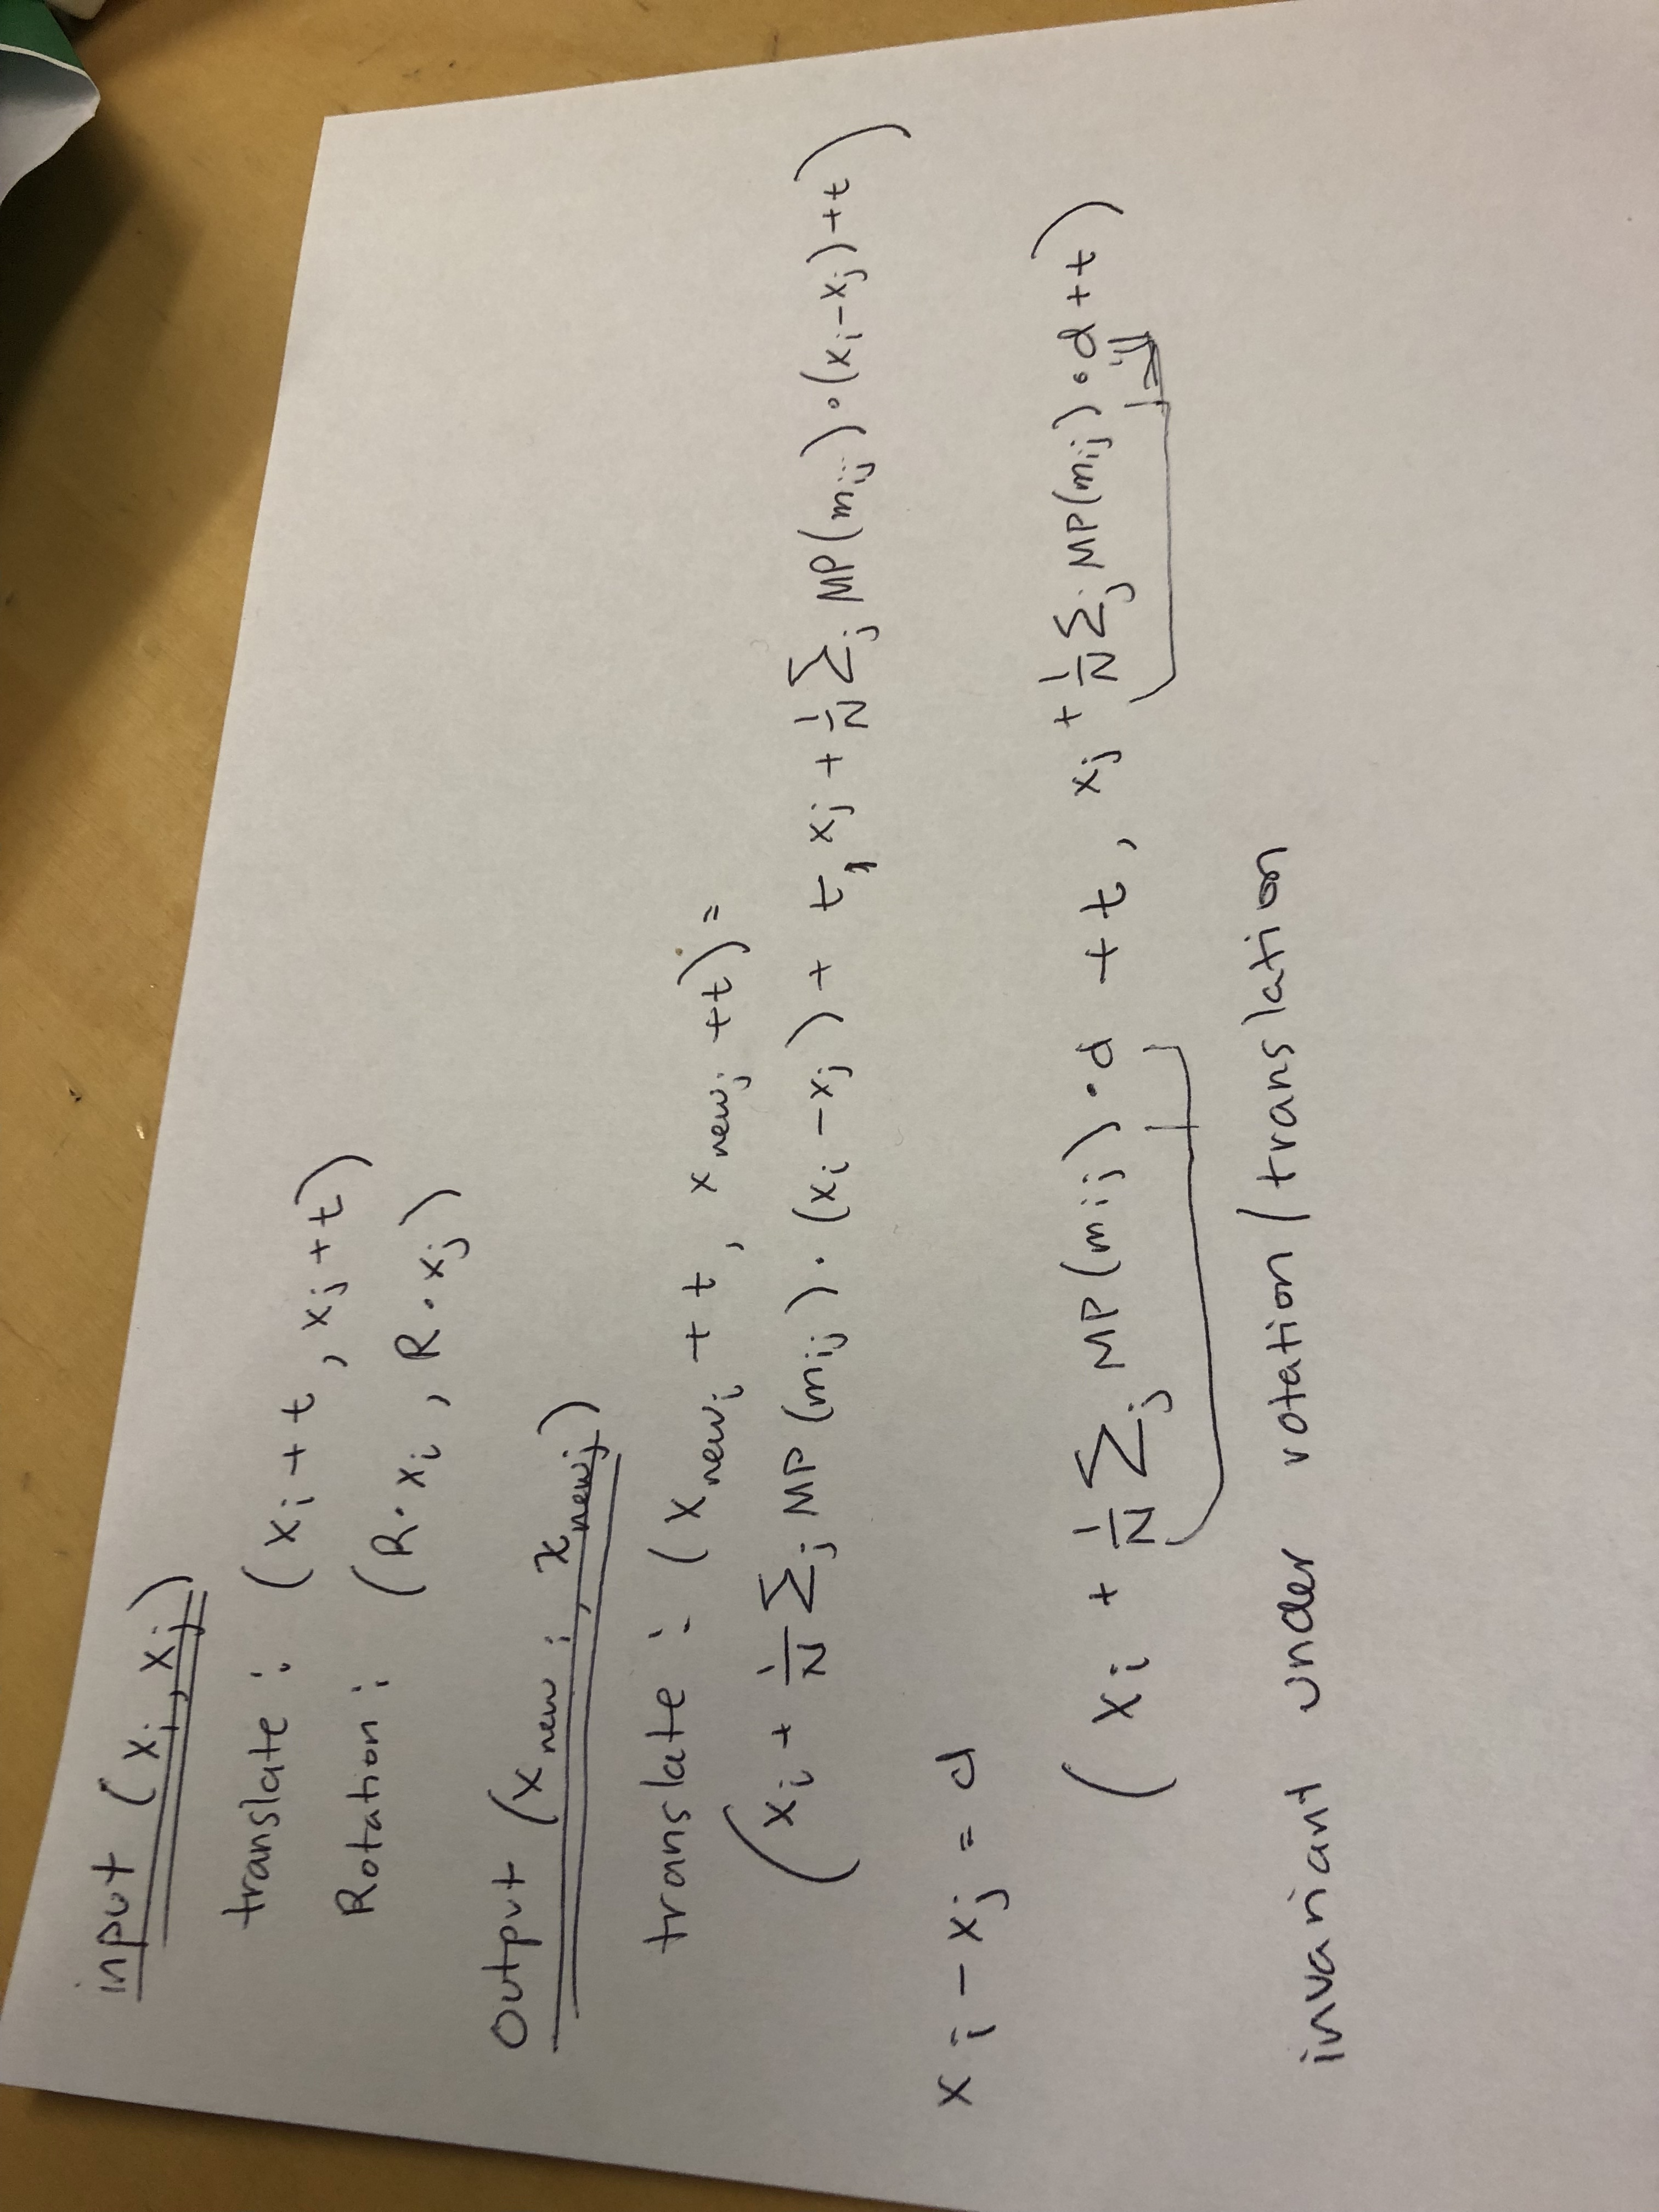

In [27]:
from IPython.display import Image
def display_image(file_name):
  return(Image(filename=file_name))

display_image("/content/IMG_2455.jpg")


#### 2.A.3 Question

We will now implement the EGNN and verify its equivariance. Fill out the code below.



In [6]:
import numpy as np
from scipy.spatial.transform import Rotation
# HELPERS
class MLP(object):
  """A random two layer neural network."""

  def __init__(self, in_dim, out_dim):
    self.w1 = np.random.randn(in_dim, out_dim)
    self.b1 = np.random.randn(out_dim)
    self.w2 = np.random.randn(out_dim, out_dim)
    self.b2 = np.random.randn(out_dim)

  def forward(self, h):
    h_new = np.dot(h, self.w1) + self.b1
    h_new = h_new * (h_new > 0)
    h_new = np.dot(h_new, self.w2) + self.b2
    return h_new

  def __call__(self, h):
    return self.forward(h)


def apply_transform(R, t, x):
  """Apply a rotation and translation to a set of points."""
  return np.dot(x, R.T) + t


# COMPLETE BELOW
class EGNN(object):

  def __init__(self, dim):
    """Random weight initialization."""
    self.message_mlp = MLP(dim * 3 + 1, dim)
    self.feature_mlp = MLP(dim * 2, dim)
    self.coords_mlp = MLP(dim, 1)

  def forward(self, h, e, x):
    """Apply an EGNN layer.

    Parameters
    ----------
    h:
      node features as a numpy array of shape (N, D)
    e:
      edge features as a numpy array of shape (N, N, D)
    x:
      set of points in 3D as a numpy array of shape (N, 3)

    Returns
    -------
    h_new:
      new node features as a numpy array of shape (N, D)
    x_new:
      new set of points in 3D as a numpy array of shape (N, 3)

    """
    N, D = h.shape

    # Expand h to get all pairs of h's, your final dimension should be (N, N, 2 * D)
    h_expanded = np.repeat(h[:, np.newaxis, :], N, axis=1)  # Repeat along the second axis
    h_expanded = np.tile(h_expanded, (1, N, 1))
    print(np.size(h_expanded))
    # Get all x_i - x_j vectors (you can just broadcast, without repeat)
    x_diff = x[:, np.newaxis, :] - x[np.newaxis, :, :]
    print("2")
    # Compute the squared norm of the x_ij vectors
    x_norm_sq = np.sum(x_diff**2, axis=-1, keepdims=True)
    print("3")
    # Concatenate h pairs, distances, and edge features
    inputs = np.concatenate([h_expanded, e, np.sqrt(x_norm_sq)], axis=-1)
    print("4")
    print("Shape of inputs:", inputs.shape)

    # Compute messages for all i, j pairs using the message MLP
    print("4b")
    messages = self.message_mlp(inputs)
    print("5")
    # Aggregate messages per node (sum across j)
    aggregated_messages = np.sum(messages, axis=1)
    print("6")
    # Update features using the feature MLP
    updated_features = self.feature_mlp(np.concatenate([h, aggregated_messages], axis=-1))
    print("7")
    # Update coordinates using the coordinates MLP
    x_new = x + self.coords_mlp(updated_features)
    print("8")
    return updated_features, x_new


# DO NOT MODIFY BELOW
def test_equivariance():
  # Set parameters
  N = 64
  D = 32
  h = np.random.randn(N, D)
  e = np.random.randn(N, N, D)
  x = np.random.randn(N, 3)
  egnn = EGNN(D)

  # Sample a random roto-translation
  R = Rotation.random().as_matrix()
  t = np.random.randn(3)
  x_rot = apply_transform(R, t, x)

  # Run model on x
  _, x_new = egnn.forward(h, e, x)
  x_new_rot = apply_transform(R, t, x_new)

  # Run the model on x_rot
  _, x_rot_new = egnn.forward(h, e, x_rot)

  # Compare the outputs
  if np.linalg.norm(x_new_rot - x_rot_new, axis=-1).max() < 1e-4:
    print("Equivariance test passed!")
  else:
    print("Equivariance test failed!")


test_equivariance()

8388608
2
3


ValueError: ignored

### 2.B DiffDock

In this second part, we will use a state of the art deep learning tool, DiffDock, to produce candidate docking structures. We will analyze the results to get some insight into the inner workings of the model.

DiffDock also uses a 3D equivariant model, though it is not the EGNN introduced above but a tensor field network. These are more complex, and we will not study them in this course. If you are interested, you may read more about them here:
https://arxiv.org/abs/1802.08219. For this problem, we will instead focus on a different charachteristic of DiffDock: the "diffusion" process.

#### 2.B.1 Question

DiffDock is a generative model. Explain the difference between a generative and a discriminative model.

**ANSWER**:
* Generative models model the entire joint probability distribution of features and labels, allowing them to generate new data.
* Discriminative models focus on the conditional probability distribution of labels given the input features, making them suitable for classification tasks.
* Generative models often require more data and computational resources compared to discriminative models.
* Discriminative models are generally more straightforward to train and can perform well in tasks where the emphasis is on classification.

#### 2.B.2 Question

DiffDock is a specific type of generative model, namely a diffusion-based model. These models are trained to iteratively reverse a noise distribution (ex: gaussian) to the data distribution. Due to their generative nature, they can be sampled from, and every sample requires a certain number of denoising steps. For more info, see this very good blog post:

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

You are provided with pre-computed structures from DiffDock for this problem. If you are interested in making your own predictions you may use this colab notebook:

https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb

We pre-computed docking results using the notebook above with different number of denoising steps (i.e inference steps): 5, 10, 20. For each setting we sampled 5 possible poses. First let's print the data we have.

In [11]:
# RUN THIS
DIFFDOCK_DATA = "/content/diffdock/diffdock/"
GT_PATH = "6o5g_B_LMJ.sdf"

ground_truth = os.path.join(DIFFDOCK_DATA, GT_PATH)
predictions = []
for file_name in os.listdir(DIFFDOCK_DATA):
  if "rank" not in file_name:
    continue
  else:
    meta = file_name.split("_")
    group = meta[0]
    rank = int(meta[2][-1])
    confidence = float(meta[3].split("confidence")[1][:-4])
    predictions.append({
        "path": os.path.join(DIFFDOCK_DATA, file_name),
        "group": group,
        "rank": rank,
        "confidence": confidence
    })

print("Ground truth path:\n")
print(ground_truth)

print("\nPredictions:")
print(pd.DataFrame(predictions))

Ground truth path:

/content/diffdock/diffdock/6o5g_B_LMJ.sdf

Predictions:
                                                 path group  rank  confidence
0   /content/diffdock/diffdock/20_iter_rank3_confi...    20     3       -1.37
1   /content/diffdock/diffdock/20_iter_rank4_confi...    20     4       -2.28
2   /content/diffdock/diffdock/10_iter_rank2_confi...    10     2       -1.14
3   /content/diffdock/diffdock/5_iter_rank3_confid...     5     3       -4.81
4   /content/diffdock/diffdock/5_iter_rank5_confid...     5     5       -4.81
5   /content/diffdock/diffdock/10_iter_rank1_confi...    10     1       -0.92
6   /content/diffdock/diffdock/20_iter_rank2_confi...    20     2       -0.93
7   /content/diffdock/diffdock/5_iter_rank4_confid...     5     4       -4.81
8   /content/diffdock/diffdock/5_iter_rank1_confid...     5     1       -3.24
9   /content/diffdock/diffdock/10_iter_rank4_confi...    10     4       -2.64
10  /content/diffdock/diffdock/5_iter_rank2_confid...     5     2 

For each of the 3 groups (i.e 5, 10 and 20), report the best RMSD across the 5 samples. How did performance change as a function of the number of denoising steps?

In [12]:
# HELPERS
def load_coordinates_sdf(path):
    """Load molecule from sdf."""
    suppl = Chem.SDMolSupplier(path)
    mol = next(suppl)
    return mol

def compute_rmsd(mol1, mol2):
    """Compute the RMSD between mol1 and mol2."""
    return Chem.rdMolAlign.CalcRMS(mol1, mol2)

ground_truth_mol = load_coordinates_sdf(ground_truth)

for group in [5, 10, 20]:
    group_predictions = [pred for pred in predictions if pred["group"] == str(group)]
    best_rmsd = float('inf')  # Initialize with a large value

    for pred in group_predictions:
        pred_path = pred["path"]
        predicted_mol = load_coordinates_sdf(pred_path)
        rmsd = compute_rmsd(ground_truth_mol, predicted_mol)

        if rmsd < best_rmsd:
            best_rmsd = rmsd

    print(f"Group {group} - Best RMSD: {best_rmsd}")

Group 5 - Best RMSD: 4.242309348823008
Group 10 - Best RMSD: 6.787675336498035
Group 20 - Best RMSD: 5.525331152200877


[16:04:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


**ANSWER:**

#### 2.B.3 Question

Perform the same analysis, this time comparing strategies for measuring performance across the 5 samples:

- The mean RMSD (same as before)
- The best RMSD of the 5 samples
- The highest confidence ranked of the 5 samples

Comment on your observations.

In [13]:
ground_truth_mol = load_coordinates_sdf(ground_truth)

for group in [5, 10, 20]:
    group_predictions = [pred for pred in predictions if pred["group"] == str(group)]

    # Initialize variables for mean RMSD, best RMSD, and highest confidence
    mean_rmsd = 0
    best_rmsd = float('inf')  # Initialize with a large value
    highest_confidence = 0

    for pred in group_predictions:
        pred_path = pred["path"]
        predicted_mol = load_coordinates_sdf(pred_path)
        rmsd = compute_rmsd(ground_truth_mol, predicted_mol)

        # Update mean RMSD
        mean_rmsd += rmsd

        # Update best RMSD
        if rmsd < best_rmsd:
            best_rmsd = rmsd

        # Update highest confidence
        if np.absolute(pred["confidence"]) > np.absolute(highest_confidence):
            highest_confidence = pred["confidence"]

    # Calculate mean RMSD
    mean_rmsd /= len(group_predictions)

    print(f"\nGroup {group} - Performance Metrics:")
    print(f"Mean RMSD: {mean_rmsd}")
    print(f"Best RMSD: {best_rmsd}")
    print(f"Highest Confidence: {highest_confidence}")


Group 5 - Performance Metrics:
Mean RMSD: 47.3111575996238
Best RMSD: 4.242309348823008
Highest Confidence: -4.81

Group 10 - Performance Metrics:
Mean RMSD: 23.46965979839937
Best RMSD: 6.787675336498035
Highest Confidence: -3.11

Group 20 - Performance Metrics:
Mean RMSD: 12.082125136730186
Best RMSD: 5.525331152200877
Highest Confidence: -2.51


[16:04:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


**ANSWER:**

#### 2.B.4 Question

Visualize the worst and the best prediction (according to the RMSD) using the Molstar visualizer (https://molstar.org/viewer/).

You can just drag and drop the files directly on your browser, super easy. Make sure to visualize both the sdf file (molecule prediction) and the ground truth PDB (target protein + correct molecule pose). Take screenshots for tbe best and worst predictions and display them here.

In [18]:
best_rmsd_index = min(range(len(predictions)), key=lambda i: predictions[i]["confidence"])
print(best_rmsd_index)
best_prediction_path = predictions[best_rmsd_index]["path"]
print(best_prediction_path)
worst_rmsd_index = max(range(len(predictions)), key=lambda i: predictions[i]["confidence"])
worst_prediction_path = predictions[worst_rmsd_index]["path"]
print(worst_prediction_path)


3
/content/diffdock/diffdock/5_iter_rank3_confidence-4.81.sdf
/content/diffdock/diffdock/20_iter_rank1_confidence-0.63.sdf


In [19]:
# Set the best file and download it by running this cell
# Do not include the /content/diffdock/diffdock prefix
best_prediction = "/content/diffdock/diffdock/5_iter_rank3_confidence-4.81.sdf"
worst_prediction = "/content/diffdock/diffdock/20_iter_rank1_confidence-0.63.sdf"

# Download
from google.colab import files

DIFFDOCK_DATA = "/content/diffdock/diffdock/"
files.download(os.path.join(DIFFDOCK_DATA, best_prediction))
files.download(os.path.join(DIFFDOCK_DATA, worst_prediction))
files.download(os.path.join(DIFFDOCK_DATA, "6O5G.pdb"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

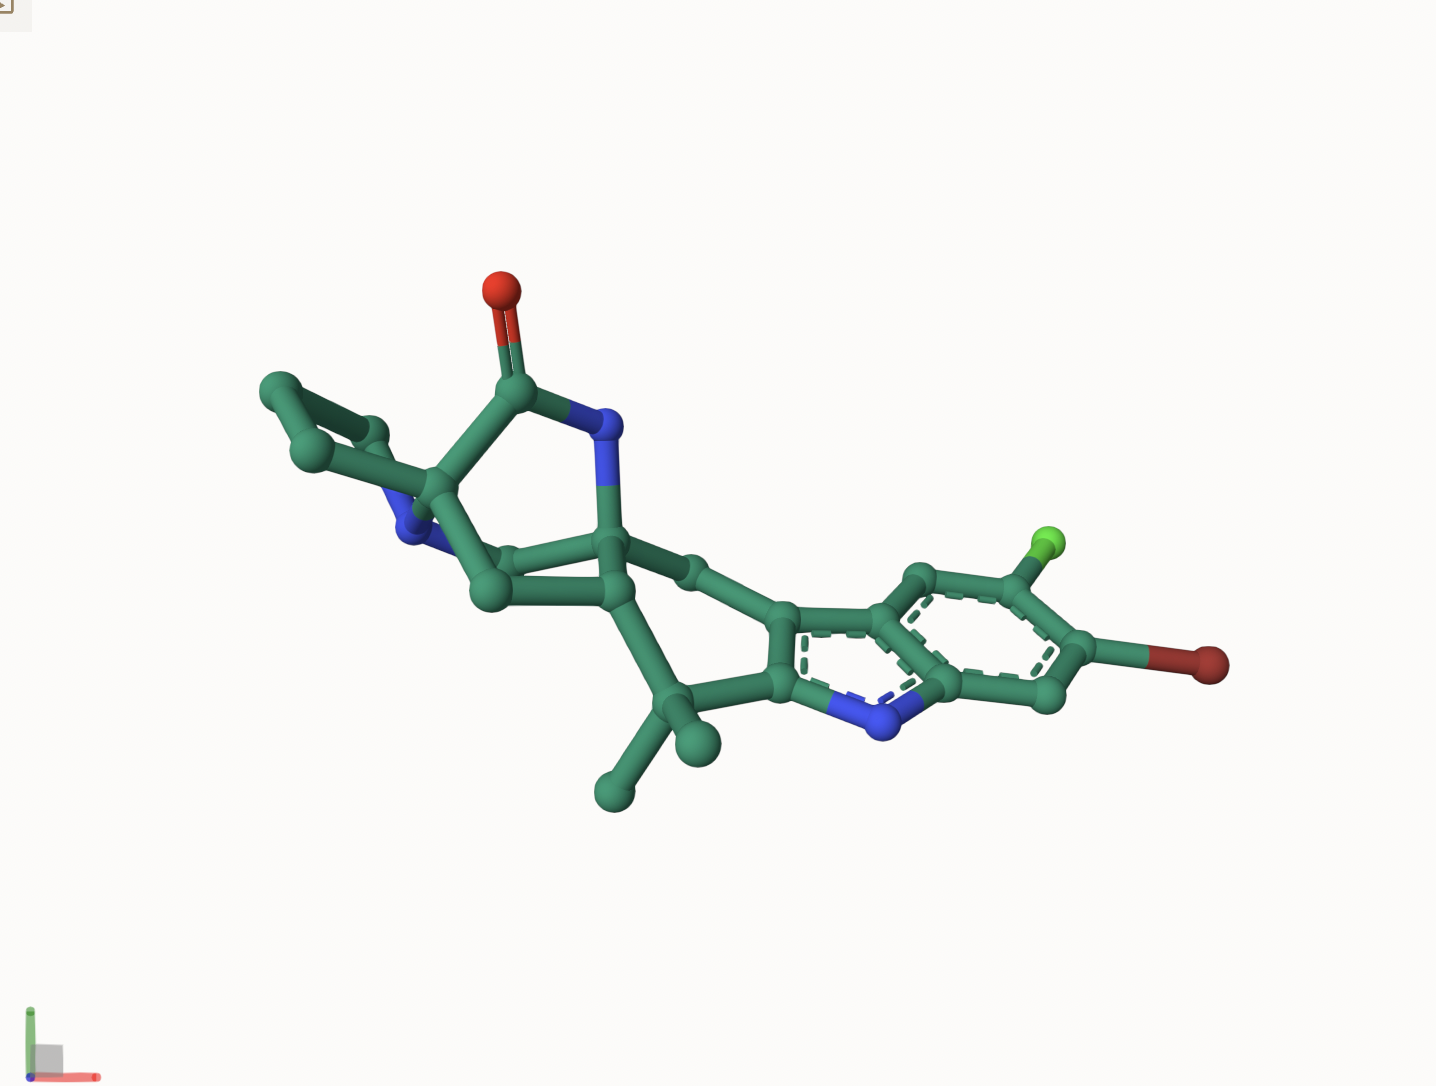

In [23]:
from IPython.display import Image
def display_image(file_name):
  return(Image(filename=file_name))

display_image("/content/Screen Shot 2023-11-13 at 11.12.21 AM.png")


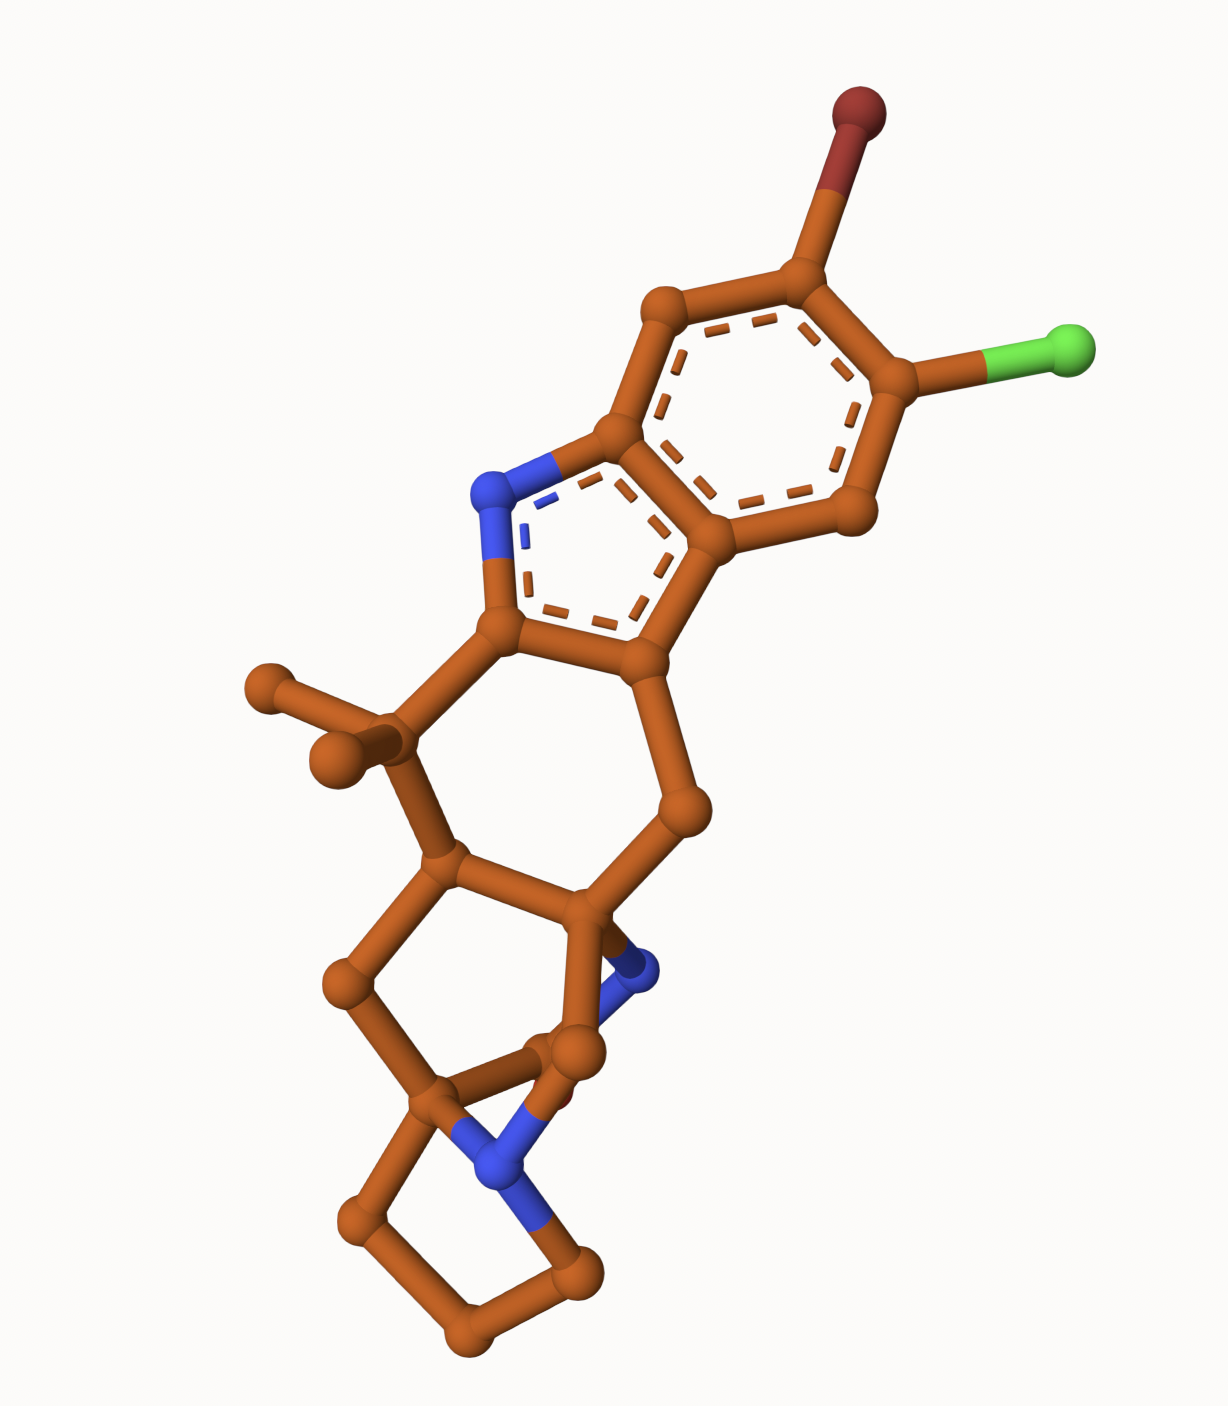

In [24]:
display_image("/content/Screen Shot 2023-11-13 at 11.14.11 AM.png")

Do you notice anything interesting about the "bad" prediction?

**ANSWER:** The bad structure is positioned very far away from the molucule. It does not seem to be docking at all

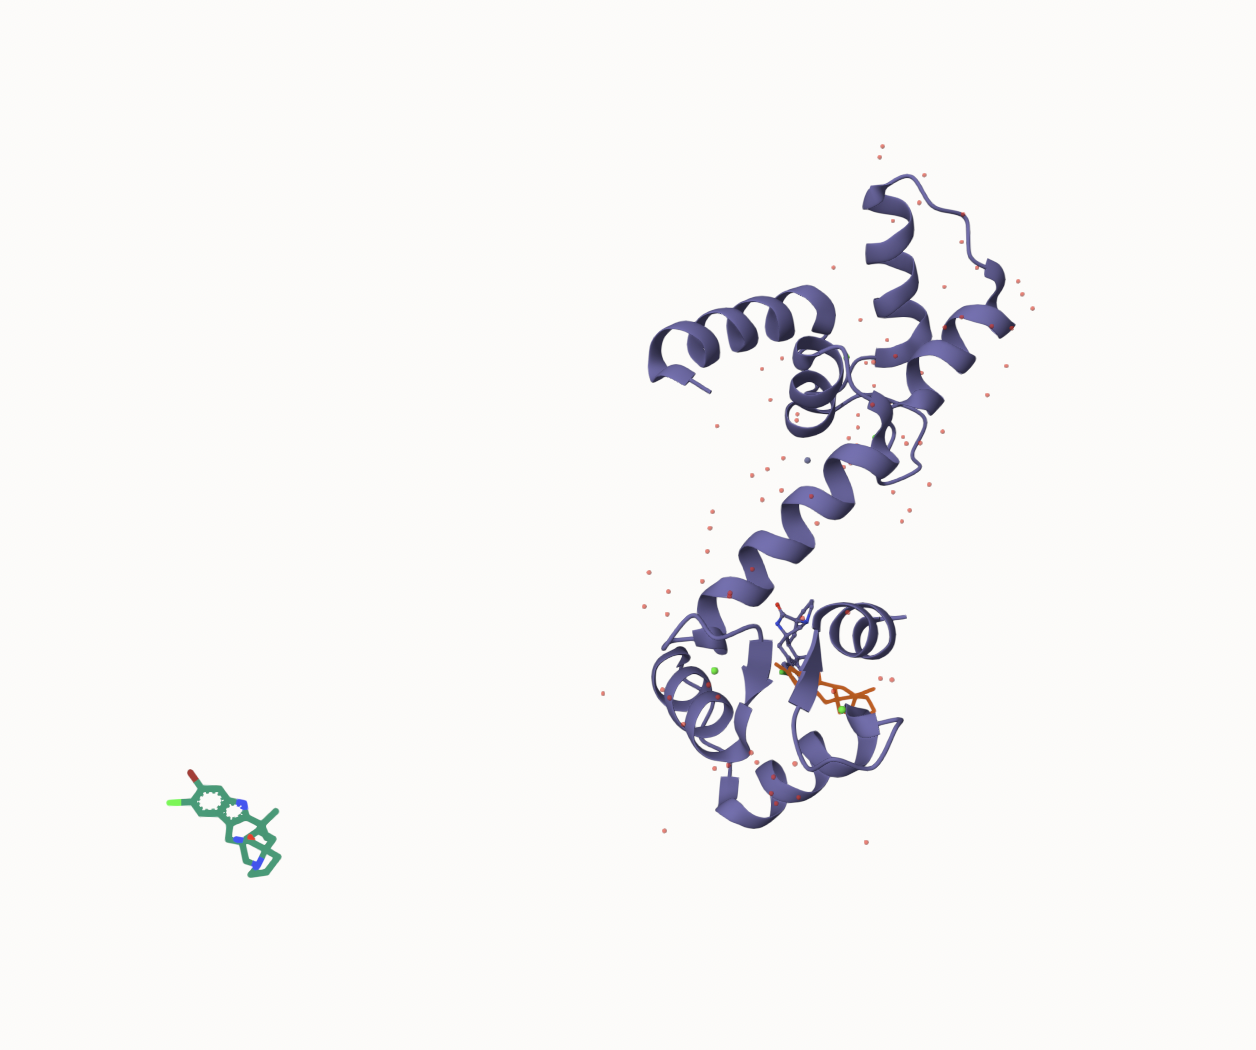

In [28]:
display_image("/content/Screen Shot 2023-11-13 at 12.27.09 PM.png")

#### 2.B.5 Question (Optional for all students)

Try your own! Find a known protein-drug interaction and attempt to dock the molecule. Here are the steps you can follow:

1. Find a known protein-drug interaction in the Drugbank: https://go.drugbank.com/
2. Get the PDB ID for the target protein (if there isn't one, look for a uniprot ID and find the predicted structure in the AlphaFold2 database: https://alphafold.ebi.ac.uk/)
3. Get the smiles string for the ligand
4. Dock using this notebook: https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb
5. Display your prediction here, you can use https://molstar.org/viewer/